# A lighter sandbox for quick development and ensembling of components
## Currently in progress: pipeline for route shape SQL query through Carto
## Objectives:
0. determine which route to use (may have different routes for a given bus line)
1. generate a gpd and a shapefile for route shape
2. plot the route on canvas and on gmap API

In [1]:
# import packages
from __future__ import print_function, division

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import fiona
import geopandas as gpd
from shapely.geometry import Point

from fetchbus import bus_data, plot_tsd

In [3]:
# import with py 2 and py 3 compatibility
try:
    import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

import ast

In [4]:
# load historical AVL data
df = pd.read_csv("B54-0-Sat-180317-160351-14400.csv")
df.head()

,Unnamed: 0,Latitude,Longitude,StopName,StopStatus,VehDistAlongRoute,VehicleRef
0,0,40.696318,-73.941015,MYRTLE AV/MARCUS GARVEY BL,at stop,4261.01,3972
1,1,40.696951,-73.935516,MYRTLE AV/BROADWAY,at stop,4729.87,4043
2,2,40.693858,-73.962420,MYRTLE AV/CLASSON AV,approaching,2435.73,6585
3,0,40.696325,-73.940951,MYRTLE AV/MARCUS GARVEY BL,at stop,4266.46,3972
4,1,40.694041,-73.960829,MYRTLE AV/CLASSON AV,at stop,2571.41,6585


(<matplotlib.figure.Figure at 0x115f0b588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115f32c88>)

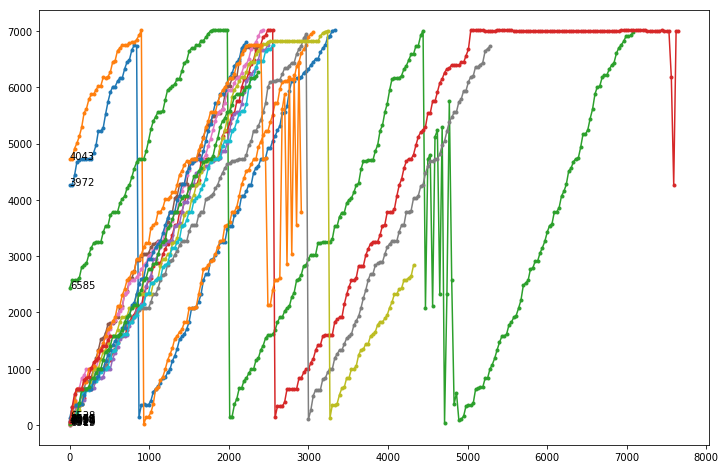

In [5]:
# plot the time-space diagram
plot_tsd(df)

In [7]:
# set SQL source
SQL_SOURCE = 'https://ywc249.carto.com/api/v2/sql?q='

# define query function
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """
    Queries carto datasets from a given carto account
    
    ARGUMENTS
    ----------
    query: a valid sql query string
    format: outlut format (default: CSV)
    source: a valid sql api endpoint OPTIONAL (default: Carto ywc249 account)

    RETURN
    ----------
    - the return of the sql query AS A STRING
    
    NOTES
    ----------
    designed for the carto API, tested only with CSV return format
    """
    
    data = urlencode({'format':format, 'q':query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [8]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files
route = 'M15'
boro = route[0].lower() # make query from respecttive GTFS shape csv

test = '''
SELECT *
FROM shapes_{}
WHERE shape_id LIKE '{}%'
ORDER BY shape_id, shape_pt_sequence
'''.format(boro, route)

shape = pd.read_csv(io(queryCartoDB(test)), sep=',')
shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,NaN,17218,NaN,M150402,40.803181,-73.932487,10001
1,NaN,17219,NaN,M150402,40.803318,-73.932816,10002
2,NaN,17220,NaN,M150402,40.803356,-73.932921,10003
3,NaN,17221,NaN,M150402,40.803422,-73.933083,10004
4,NaN,17222,NaN,M150402,40.802753,-73.933571,10005


In [9]:
# create Point geom
shape['the_geom'] = [Point(shape.iloc[i,5], shape.iloc[i,4]) for i in range(len(shape))]
shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,POINT (-73.93248699999999 40.803181),17218,NaN,M150402,40.803181,-73.932487,10001
1,POINT (-73.932816 40.803318),17219,NaN,M150402,40.803318,-73.932816,10002
2,POINT (-73.93292099999999 40.803356),17220,NaN,M150402,40.803356,-73.932921,10003
3,POINT (-73.933083 40.803422),17221,NaN,M150402,40.803422,-73.933083,10004
4,POINT (-73.933571 40.802753),17222,NaN,M150402,40.802753,-73.933571,10005


In [10]:
shape_gdf = gpd.GeoDataFrame(shape)